# Dependencies

In [ ]:
#!pip install TSNE --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.6/547.6 kB 3.7 MB/s eta 0:00:00
  Installing build dependencies ... canceled
ERROR: Operation cancelled by user


In [ ]:
import pandas as pd
import calendar
from pandas.api.types import CategoricalDtype
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Import data
Summary: 
- 1 missing data in 'Customer Name'
- 0 duplicates
- assume two target variables: 'Claim amount' and if it is larger than 0 (Referred to as severity and frequency in the actuarial literature)

In [ ]:
raw_df = pd.read_csv("insurance_data_sample.csv")
raw_df.head()

,Car_id,Date,Customer Name,Gender,Annual Income,Dealer_Name,Company,Model,Engine,Transmission,Color,Price ($),Dealer_No,Body Style,Phone,Amount_paid_for_insurance,Claim amount,City
0,C_CND_000001,01/02/2022,Geraldine,Male,13500,Buddy Storbeck's Diesel Service Inc,Ford,Expedition,DoubleÃ‚Â Overhead Camshaft,Auto,Black,26000,06457-3834,SUV,8264678,1665,0.0,Riga
1,C_CND_000002,01/02/2022,Gia,Male,1480000,C & M Motors Inc,Dodge,Durango,DoubleÃ‚Â Overhead Camshaft,Auto,Black,19000,60504-7114,SUV,6848189,1332,1900.0,Liepaja
2,C_CND_000003,01/02/2022,Gianna,Male,1035000,Capitol KIA,Cadillac,Eldorado,Overhead Camshaft,Manual,Red,31500,38701-8047,Passenger,7298798,1897,0.0,Riga
3,C_CND_000004,01/02/2022,Giselle,Male,13500,Chrysler of Tri-Cities,Toyota,Celica,Overhead Camshaft,Manual,Pale White,14000,99301-3882,SUV,6257557,1176,0.0,Jelgava
4,C_CND_000005,01/02/2022,Grace,Male,1465000,Chrysler Plymouth,Acura,TL,DoubleÃ‚Â Overhead Camshaft,Auto,Red,24500,53546-9427,Hatchback,7081483,1323,2450.0,Liepaja


In [ ]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23906 entries, 0 to 23905
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Car_id                     23906 non-null  object 
 1   Date                       23906 non-null  object 
 2   Customer Name              23905 non-null  object 
 3   Gender                     23906 non-null  object 
 4   Annual Income              23906 non-null  int64  
 5   Dealer_Name                23906 non-null  object 
 6   Company                    23906 non-null  object 
 7   Model                      23906 non-null  object 
 8   Engine                     23906 non-null  object 
 9   Transmission               23906 non-null  object 
 10  Color                      23906 non-null  object 
 11  Price ($)                  23906 non-null  int64  
 12  Dealer_No                  23906 non-null  object 
 13  Body Style                 23906 non-null  obj

In [ ]:
# List columns containing missing data
raw_df.columns[raw_df.isna().any()].tolist()

['Customer Name']

In [ ]:
# Get the duplicated rows if any
duplicated_rows = raw_df[raw_df.duplicated(keep=False)]
duplicated_rows

,Car_id,Date,Customer Name,Gender,Annual Income,Dealer_Name,Company,Model,Engine,Transmission,Color,Price ($),Dealer_No,Body Style,Phone,Amount_paid_for_insurance,Claim amount,City


# EDA + Feature engineering

&: New columns created from this column \
†: This column is dropped \
*: Rows removed/modified due to this column; results saved in raw_df_cleaned, will need to come back to get this new df when needed

## Car_id†
Droped since it is simply another index.

In [ ]:
# Check if length == Index
raw_df['Car_id'].max()

'C_CND_023906'

In [ ]:
# Sample data creation
Car_id_data = {
    'Car_id': [f'C_CND_{str(i).zfill(6)}' for i in range(1, 23907)]
}
Car_id_df = pd.DataFrame(Car_id_data)

# Extract the numeric part from the column
Car_id_df['extracted_number'] = raw_df['Car_id'].str.extract(r'C_CND_(\d{6})').astype(int)

# Check if extracted numbers match the index (considering index starts from 0)
Car_id_df['index'] = raw_df.index

# Check if the extracted numbers are equal to the index + 1
Car_id_df['match'] = Car_id_df['extracted_number'] == (Car_id_df.index + 1)

# Check if all values match
all_match = Car_id_df['match'].all()

print("Do all values in the column match the index? ", all_match)


Do all values in the column match the index?  True


In [ ]:
raw_df = raw_df.drop('Car_id', axis=1)

## Date&†
Create 'Year', 'Month', 'Day', 'Day_of_week' from this column and then drop it.

In [ ]:
# Check the format
raw_df['Date'].iloc[-1]

'12/31/2023'

In [ ]:
# Enforce the format while converting to datetime
raw_df['Date'] = pd.to_datetime(raw_df['Date'], format = "%m/%d/%Y")

In [ ]:
# Inspection
raw_df['Date'].min()

Timestamp('2022-01-02 00:00:00')

In [ ]:
# Inspection
raw_df['Date'].max()

Timestamp('2023-12-31 00:00:00')

In [ ]:
# Create new features
raw_df['Year'] = raw_df['Date'].dt.year
raw_df['Month'] = raw_df['Date'].dt.month
raw_df['Day'] = raw_df['Date'].dt.day
raw_df['Day_of_week'] = raw_df['Date'].dt.dayofweek
for i in ['Year', 'Month', 'Day', 'Day_of_week']:
    raw_df[i] = raw_df[i].astype('category')

In [ ]:
# Change column order
raw_df = raw_df[['Date', 'Year', 'Month',
       'Day', 'Day_of_week', 'Customer Name', 'Gender', 'Annual Income',
       'Dealer_Name', 'Company', 'Model', 'Engine', 'Transmission', 'Color',
       'Price ($)', 'Dealer_No ', 'Body Style', 'Phone',
       'Amount_paid_for_insurance', 'Claim amount', 'City']]

In [ ]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23906 entries, 0 to 23905
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Date                       23906 non-null  datetime64[ns]
 1   Year                       23906 non-null  category      
 2   Month                      23906 non-null  category      
 3   Day                        23906 non-null  category      
 4   Day_of_week                23906 non-null  category      
 5   Customer Name              23905 non-null  object        
 6   Gender                     23906 non-null  object        
 7   Annual Income              23906 non-null  int64         
 8   Dealer_Name                23906 non-null  object        
 9   Company                    23906 non-null  object        
 10  Model                      23906 non-null  object        
 11  Engine                     23906 non-null  object        
 12  Tran

<Axes: xlabel='Year'>

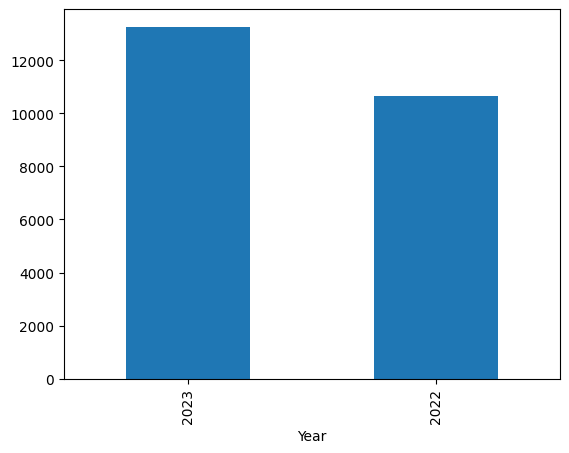

In [ ]:
# Instpection: plot the year
raw_df['Year'].value_counts().plot(kind='bar')

<Axes: xlabel='Month'>

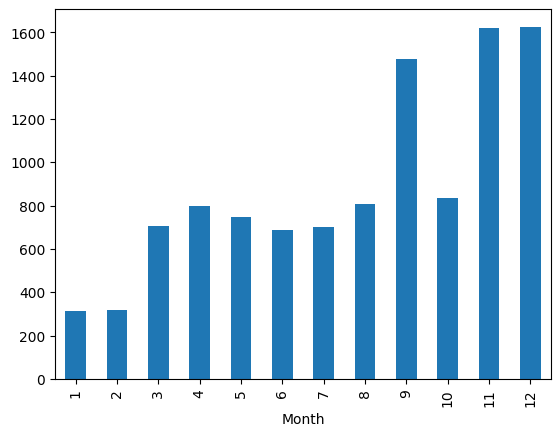

In [ ]:
# Instpection: plot the months (2022)
raw_df[raw_df['Year']==2022]['Month'].value_counts().sort_index().plot(kind='bar')

<Axes: xlabel='Month'>

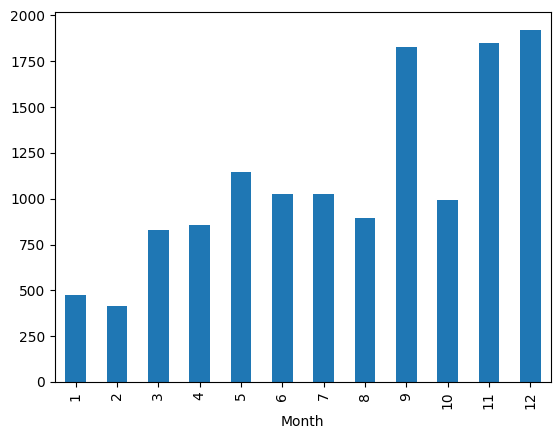

In [ ]:
# Instpection: plot the months (2023)
raw_df[raw_df['Year']==2023]['Month'].value_counts().sort_index().plot(kind='bar')

[Text(0, 0, 'Monday'),
 Text(1, 0, 'Tuesday'),
 Text(2, 0, 'Wednesday'),
 Text(3, 0, 'Thursday'),
 Text(4, 0, 'Friday'),
 Text(5, 0, 'Saturday'),
 Text(6, 0, 'Sunday')]

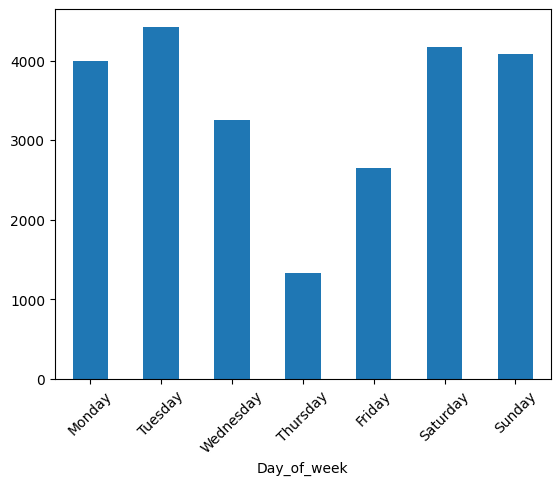

In [ ]:
# Instpection: plot the days of the week
#import calendar
weekday_names = [calendar.day_name[i] for i in range(7)]

weekday_plot = raw_df['Day_of_week'].value_counts().sort_index().plot(kind='bar')
weekday_plot.set_xticklabels(weekday_names, rotation=45)

In [ ]:
# Replace numerical values with weekday names
raw_df['Day_of_week'] = raw_df['Day_of_week'].map(lambda x: weekday_names[x])

# Convert to categorical dtype and set to ordered
#from pandas.api.types import CategoricalDtype
raw_df['Day_of_week'] = raw_df['Day_of_week'].astype(CategoricalDtype(categories = weekday_names, ordered = True))
raw_df['Day_of_week'].dtype

CategoricalDtype(categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday',
                  'Saturday', 'Sunday'],
, ordered=True)

In [ ]:
raw_df = raw_df.drop('Date', axis=1)

## Customer Name*†
The Only missing name is set to "Unknown" as if that is a name, so as not to having to remove this row entirely. \
This column is eventually dropped since first names cannot identify unique customers, and it doesn't make business sense that first names will affect claims.

In [ ]:
# Find the row with NaN
raw_df[raw_df['Customer Name'].isna()]

,Year,Month,Day,Day_of_week,Customer Name,Gender,Annual Income,Dealer_Name,Company,Model,Engine,Transmission,Color,Price ($),Dealer_No,Body Style,Phone,Amount_paid_for_insurance,Claim amount,City
7564,2022,11,5,Saturday,NaN,Male,680000,Saab-Belle Dodge,Dodge,Ram Pickup,DoubleÃ‚Â Overhead Camshaft,Auto,Pale White,45000,60504-7114,Hardtop,7203103,2638,0.0,Liepaja


In [ ]:
# Check if 'Unknown' is already in use to avoid duplicates
raw_df[raw_df['Customer Name'] == 'Unknown']

,Year,Month,Day,Day_of_week,Customer Name,Gender,Annual Income,Dealer_Name,Company,Model,Engine,Transmission,Color,Price ($),Dealer_No,Body Style,Phone,Amount_paid_for_insurance,Claim amount,City


In [ ]:
# Fill in the name as 'Unknown' in the raw_df_cleaned
raw_df_cleaned = raw_df.copy()
raw_df_cleaned['Customer Name'] = raw_df_cleaned['Customer Name'].fillna('Unknown')
raw_df_cleaned.iloc[7563:7566]['Customer Name']

7563      Jonah
7564    Unknown
7565       Iris
Name: Customer Name, dtype: object

In [ ]:
# Double check
raw_df_cleaned[raw_df_cleaned['Customer Name'] == 'Unknown']

,Year,Month,Day,Day_of_week,Customer Name,Gender,Annual Income,Dealer_Name,Company,Model,Engine,Transmission,Color,Price ($),Dealer_No,Body Style,Phone,Amount_paid_for_insurance,Claim amount,City
7564,2022,11,5,Saturday,Unknown,Male,680000,Saab-Belle Dodge,Dodge,Ram Pickup,DoubleÃ‚Â Overhead Camshaft,Auto,Pale White,45000,60504-7114,Hardtop,7203103,2638,0.0,Liepaja


In [ ]:
# Convert the dtype to str to be sure, but after the nan is filled
#raw_df['Customer Name'] = raw_df['Customer Name'].astype('str')

In [ ]:
raw_df['Customer Name'].astype('str').value_counts().head(15)

Customer Name
Thomas    92
Emma      90
Lucas     88
Nathan    80
Louis     76
Lea       75
Chloe     74
Paul      71
Theo      65
Sarah     65
Hugo      64
Leo       63
Alexis    62
Dylan     61
Victor    60
Name: count, dtype: int64

In [ ]:
raw_df['Customer Name'].astype('str').value_counts().shape[0]

3022

In [ ]:
#raw_df = raw_df.drop('Customer Name', axis=1)

## Gender
Either male or female in the dataset; Male >> Female

In [ ]:
# List all distinct values in the 'Gender' column
distinct_values = raw_df['Gender'].unique()

print("Distinct values in 'Gender' column:")
print(distinct_values)

Distinct values in 'Gender' column:
['Male' 'Female']


In [ ]:
# Convert column to category dtype
raw_df['Gender'] = raw_df['Gender'].astype('category')

In [ ]:
raw_df['Gender'].value_counts()

Gender
Male      18798
Female     5108
Name: count, dtype: int64

## Annual Income
Large outliers exist and may need to be removed when modeling. See box plot.

In [ ]:
# Setting the display option to avoid scientific notation
pd.set_option('display.float_format', '{:.3f}'.format)

raw_df['Annual Income'].describe()

count      23906.000
mean      830840.285
std       720006.395
min        10080.000
25%       386000.000
50%       735000.000
75%      1175750.000
max     11200000.000
Name: Annual Income, dtype: float64

<Axes: ylabel='Frequency'>

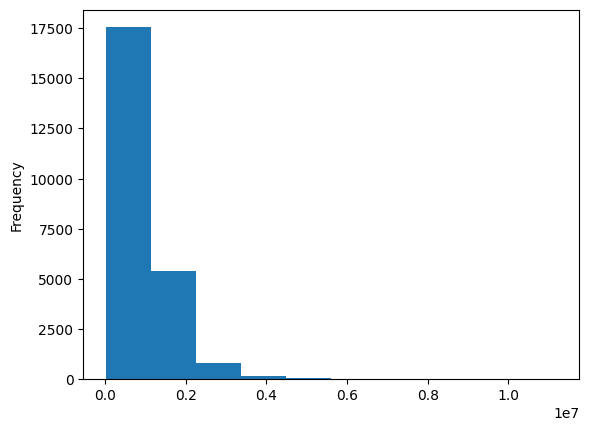

In [ ]:
raw_df['Annual Income'].plot.hist()

<Axes: ylabel='Frequency'>

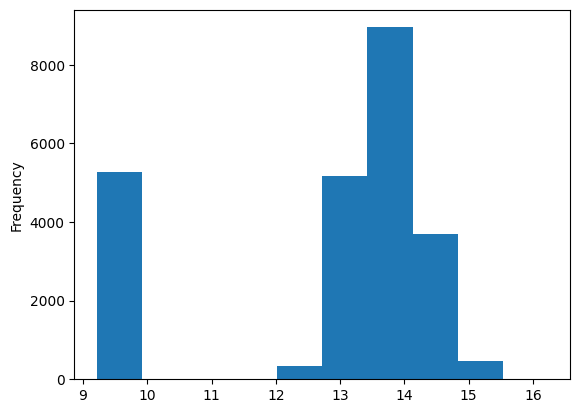

In [ ]:
#import numpy as np
np.log(raw_df['Annual Income']).plot.hist()

In [ ]:
raw_df[['Annual Income']].nlargest(20, 'Annual Income')

,Annual Income
14026,11200000
15675,8000000
6150,7650000
9996,6800000
22407,6600000
11607,6500000
7657,6460000
8817,6400000
14183,6400000
4755,6240000


In [ ]:
raw_df[raw_df['Annual Income'] >= 830840.285].shape[0]

10122

In [ ]:
raw_df[['Annual Income']].nsmallest(20, 'Annual Income')

,Annual Income
23451,10080
0,13500
3,13500
7,13500
9,13500
10,13500
11,13500
13,13500
20,13500
28,13500


In [ ]:
raw_df[raw_df['Annual Income'] == 13500].shape[0]

5273

Text(0.5, 1.0, 'Box Plot of Annual Income')

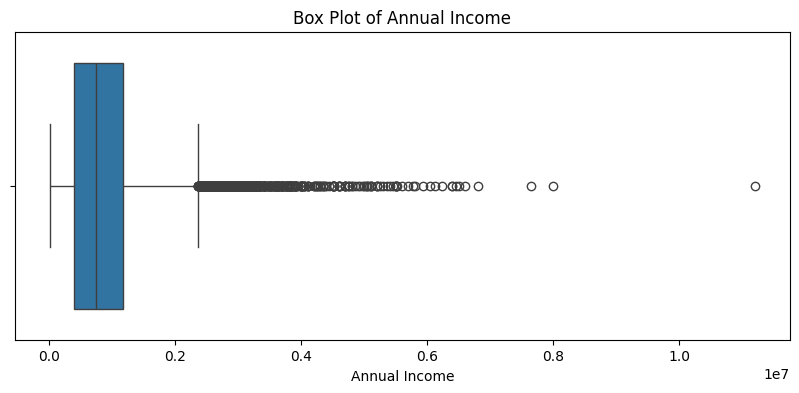

In [ ]:
plt.figure(figsize=(10, 4))
sns.boxplot(x=raw_df['Annual Income'])
plt.title(f'Box Plot of Annual Income')
#plt.show()

## Dealer_Name
Summary:
- made into categorical, but lots of levels
- is a finer division of Dealer_No: every Dealer_No correponds to 4 Dealer_Name

In [ ]:
raw_df.rename(columns={'Dealer_No ': 'Dealer_No'}, inplace=True)

In [ ]:
unique_pairs = raw_df[['Dealer_Name', 'Dealer_No']].drop_duplicates()
groupby_col1 = unique_pairs.groupby('Dealer_Name')['Dealer_No'].nunique()
condition1 = (groupby_col1 == 1).all()
groupby_col2 = unique_pairs.groupby('Dealer_No')['Dealer_Name'].nunique()
condition2 = (groupby_col2 == 1).all()

In [ ]:
condition1

True

In [ ]:
condition2

False

In [ ]:
unique_pairs.groupby('Dealer_No')['Dealer_Name'].nunique()

Dealer_No
06457-3834    4
38701-8047    4
53546-9427    4
60504-7114    4
78758-7841    4
85257-3102    4
99301-3882    4
Name: Dealer_Name, dtype: int64

In [ ]:
unique_pairs

,Dealer_Name,Dealer_No
0,Buddy Storbeck's Diesel Service Inc,06457-3834
1,C & M Motors Inc,60504-7114
2,Capitol KIA,38701-8047
3,Chrysler of Tri-Cities,99301-3882
4,Chrysler Plymouth,53546-9427
5,Classic Chevy,85257-3102
6,Clay Johnson Auto Sales,78758-7841
7,U-Haul CO,78758-7841
8,Rabun Used Car Sales,85257-3102
10,Race Car Help,78758-7841


In [ ]:
# Convert column to category dtype
raw_df['Dealer_Name'] = raw_df['Dealer_Name'].astype('category')

In [ ]:
raw_df['Dealer_Name'].value_counts()

Dealer_Name
Progressive Shippers Cooperative Association No    1318
Rabun Used Car Sales                               1313
Race Car Help                                      1253
Saab-Belle Dodge                                   1251
Tri-State Mack Inc                                 1249
Star Enterprises Inc                               1249
Ryder Truck Rental and Leasing                     1248
U-Haul CO                                          1247
Scrivener Performance Engineering                  1246
Suburban Ford                                      1243
Nebo Chevrolet                                      633
Pars Auto Sales                                     630
McKinney Dodge Chrysler Jeep                        629
New Castle Ford Lincoln Mercury                     629
Hatfield Volkswagen                                 629
Gartner Buick Hyundai Saab                          628
Capitol KIA                                         628
Pitre Buick-Pontiac-Gmc of Scottsdal

## Company
Summary:
- made into categorical, but lots of levels
- each company has several "Model"

In [ ]:
unique_companies = raw_df[['Company']].drop_duplicates()
print(unique_companies)

        Company
0          Ford
1         Dodge
2      Cadillac
3        Toyota
4         Acura
5    Mitsubishi
8     Chevrolet
11       Nissan
12      Mercury
13          BMW
14     Chrysler
15       Subaru
16      Hyundai
19        Honda
21     Infiniti
22         Audi
23      Porsche
24   Volkswagen
26        Buick
29       Saturn
31   Mercedes-B
34       Jaguar
35        Volvo
44      Pontiac
76      Lincoln
82   Oldsmobile
100       Lexus
132    Plymouth
147        Saab
365        Jeep


In [ ]:
# Convert column to category dtype
raw_df['Company'] = raw_df['Company'].astype('category')

In [ ]:
raw_df['Company'].value_counts()

Company
Chevrolet     1819
Dodge         1671
Ford          1614
Volkswagen    1333
Mercedes-B    1285
Mitsubishi    1277
Chrysler      1120
Oldsmobile    1111
Toyota        1110
Nissan         886
Mercury        874
Lexus          802
Pontiac        796
BMW            790
Volvo          789
Honda          708
Acura          689
Cadillac       652
Plymouth       617
Saturn         586
Lincoln        492
Audi           468
Buick          439
Subaru         405
Jeep           363
Porsche        361
Hyundai        264
Saab           210
Infiniti       195
Jaguar         180
Name: count, dtype: int64

## Model
Summary:
- made into categorical, but lots of levels
- the model 'Neon' can be from both 'Company == Dodge' or 'Company == Plymouth'
- can consider combining 'Model' and 'Company' into 'Company-Model' later

In [ ]:
unique_models = raw_df[['Model']].drop_duplicates()
print(unique_models)

           Model
0     Expedition
1        Durango
2       Eldorado
3         Celica
4             TL
...          ...
862        Alero
940       Mirage
1171     Century
2316       RX300
5323      Avalon

[154 rows x 1 columns]


In [ ]:
unique_pairs = raw_df[['Company', 'Model']].drop_duplicates()
groupby_col = unique_pairs.groupby('Company')['Model'].nunique()
groupby_col

Company
Acura          3
Audi           3
BMW            3
Buick          4
Cadillac       5
Chevrolet      9
Chrysler       7
Dodge         11
Ford          11
Honda          5
Hyundai        3
Infiniti       1
Jaguar         1
Jeep           3
Lexus          6
Lincoln        3
Mercedes-B     9
Mercury        6
Mitsubishi     7
Nissan         7
Oldsmobile     6
Plymouth       4
Pontiac        5
Porsche        3
Saab           2
Saturn         5
Subaru         2
Toyota         9
Volkswagen     6
Volvo          6
Name: Model, dtype: int64

In [ ]:
# Convert column to category dtype
raw_df['Model'] = raw_df['Model'].astype('category')

In [ ]:
raw_df['Model'].value_counts()

Model
Diamante         418
Prizm            411
Silhouette       411
Passat           391
Ram Pickup       383
                ... 
Mirage            19
Alero             18
Avalon            15
RX300             15
Sebring Conv.     10
Name: count, Length: 154, dtype: int64

In [ ]:
# Assuming df is your DataFrame
duplicate_models = raw_df.groupby('Model').filter(lambda x: x['Company'].nunique() > 1)

# Display the result
duplicate_models[['Model', 'Company']].head(30)

,Model,Company
364,Neon,Plymouth
366,Neon,Plymouth
425,Neon,Plymouth
464,Neon,Plymouth
675,Neon,Plymouth
951,Neon,Plymouth
1090,Neon,Plymouth
1103,Neon,Plymouth
1128,Neon,Plymouth
1138,Neon,Plymouth


In [ ]:
filtered_result = duplicate_models[duplicate_models['Model'] != 'Neon']
filtered_result

,Year,Month,Day,Day_of_week,Gender,Annual Income,Dealer_Name,Company,Model,Engine,Transmission,Color,Price ($),Dealer_No,Body Style,Amount_paid_for_insurance,Claim,Claim amount,City


In [ ]:
neon_companies = raw_df[raw_df['Model'] == 'Neon']['Company'].unique()
neon_companies

['Plymouth', 'Dodge']
Categories (30, object): ['Acura', 'Audi', 'BMW', 'Buick', ..., 'Subaru', 'Toyota', 'Volkswagen',
                          'Volvo']

In [ ]:
test_raw_df = raw_df.copy()

# Convert column to category dtype
test_raw_df['Model'] = test_raw_df['Model'].astype('str')
test_raw_df['Company'] = test_raw_df['Company'].astype('str')

test_raw_df['Company-Model'] = test_raw_df['Company'] + '-' + test_raw_df['Model']
test_raw_df['Company-Model'].head()

0      Ford-Expedition
1        Dodge-Durango
2    Cadillac-Eldorado
3        Toyota-Celica
4             Acura-TL
Name: Company-Model, dtype: object

## Engine
A two-level categorical

In [ ]:
unique_engines = raw_df[['Engine']].drop_duplicates()
print(unique_engines)

                        Engine
0  DoubleÃ‚Â Overhead Camshaft
2            Overhead Camshaft


In [ ]:
# Convert column to category dtype
raw_df['Engine'] = raw_df['Engine'].astype('category')

In [ ]:
raw_df['Engine'].value_counts()

Engine
DoubleÃ‚Â Overhead Camshaft    12571
Overhead Camshaft              11335
Name: count, dtype: int64

## Transmission
A two-level categorical

In [ ]:
unique_transmissions = raw_df[['Transmission']].drop_duplicates()
print(unique_transmissions)

  Transmission
0         Auto
2       Manual


In [ ]:
# Convert column to category dtype
raw_df['Transmission'] = raw_df['Transmission'].astype('category')

In [ ]:
raw_df['Transmission'].value_counts()

Transmission
Auto      12571
Manual    11335
Name: count, dtype: int64

## Color
A 3-level categorical

In [ ]:
unique_colors = raw_df[['Color']].drop_duplicates()
print(unique_colors)

        Color
0       Black
2         Red
3  Pale White


In [ ]:
# Convert column to category dtype
raw_df['Color'] = raw_df['Color'].astype('category')

In [ ]:
raw_df['Color'].value_counts()

Color
Pale White    11256
Black          7857
Red            4793
Name: count, dtype: int64

## Price ($)*
Large outliers exist and may need to be removed when modeling. See box plot. \
Understood as price of car.

In [ ]:
# Setting the display option to avoid scientific notation
pd.set_option('display.float_format', '{:.3f}'.format)

raw_df['Price ($)'].describe()

count   23906.000
mean    28090.248
std     14788.688
min      1200.000
25%     18001.000
50%     23000.000
75%     34000.000
max     85800.000
Name: Price ($), dtype: float64

<Axes: ylabel='Frequency'>

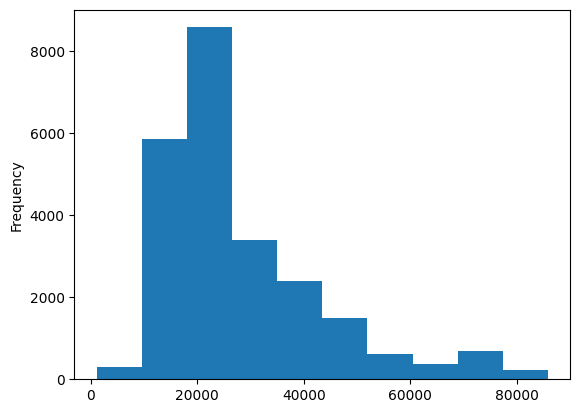

In [ ]:
raw_df['Price ($)'].plot.hist()

<Axes: ylabel='Frequency'>

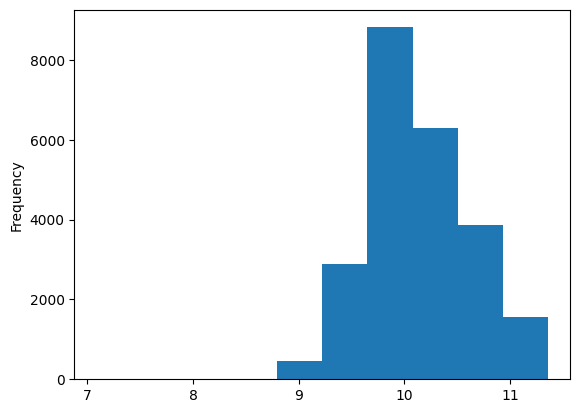

In [ ]:
#import numpy as np
np.log(raw_df['Price ($)']).plot.hist()

In [ ]:
raw_df[['Price ($)']].nsmallest(10, 'Price ($)')

,Price ($)
13946,1200
13996,1450
14010,1700
14020,2200
13949,4200
14185,4300
12,9000
260,9000
290,9000
413,9000


In [ ]:
raw_df[raw_df['Price ($)'] == 9000].shape[0]

169

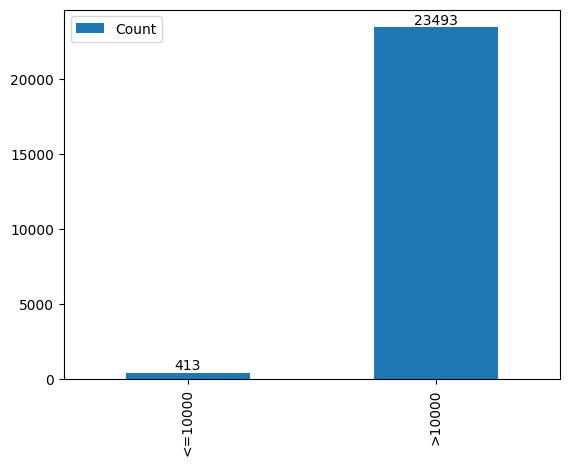

In [ ]:
# Split the column into two subgroups
cheap = raw_df[raw_df['Price ($)'] <= 10000]
expensive = raw_df[raw_df['Price ($)'] > 10000]

# Get the counts of each subgroup
cheap_count = cheap.shape[0]
expensive_count = expensive.shape[0]

# Put into df and plot
price_df = pd.DataFrame({'Count': [cheap_count, expensive_count]}, index=['<=10000', '>10000'])
price_plot = price_df.plot(kind='bar')

# Annotate each bar with its corresponding count value
for p in price_plot.patches:
    price_plot.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')

In [ ]:
raw_df_cleaned = raw_df_cleaned[raw_df_cleaned['Price ($)'] >= 9000].reset_index(drop=True)
raw_df_cleaned['Price ($)'].iloc[14009:14021]

14009    13001
14010    20400
14011    16000
14012    19001
14013    25001
14014    19501
14015    22001
14016    20001
14017    38000
14018    21001
14019    27000
14020    18001
Name: Price ($), dtype: int64

In [ ]:
raw_df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23900 entries, 0 to 23899
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   Year                       23900 non-null  category
 1   Month                      23900 non-null  category
 2   Day                        23900 non-null  category
 3   Day_of_week                23900 non-null  category
 4   Customer Name              23900 non-null  object  
 5   Gender                     23900 non-null  object  
 6   Annual Income              23900 non-null  int64   
 7   Dealer_Name                23900 non-null  object  
 8   Company                    23900 non-null  object  
 9   Model                      23900 non-null  object  
 10  Engine                     23900 non-null  object  
 11  Transmission               23900 non-null  object  
 12  Color                      23900 non-null  object  
 13  Price ($)                  2390

In [ ]:
raw_df[['Price ($)']].nlargest(10, 'Price ($)')

,Price ($)
7068,85800
17129,85601
358,85600
13605,85600
9228,85500
11330,85500
17947,85400
2661,85301
11428,85300
6530,85250


In [ ]:
raw_df[raw_df['Price ($)'] >= 85000].shape[0]

87

In [ ]:
raw_df_cleaned['Price ($)'].describe()

count   23900.000
mean    28096.670
std     14784.974
min      9000.000
25%     18001.000
50%     23000.000
75%     34000.000
max     85800.000
Name: Price ($), dtype: float64

In [ ]:
raw_df['Price ($)'].describe()

count   23906.000
mean    28090.248
std     14788.688
min      1200.000
25%     18001.000
50%     23000.000
75%     34000.000
max     85800.000
Name: Price ($), dtype: float64

<Axes: ylabel='Frequency'>

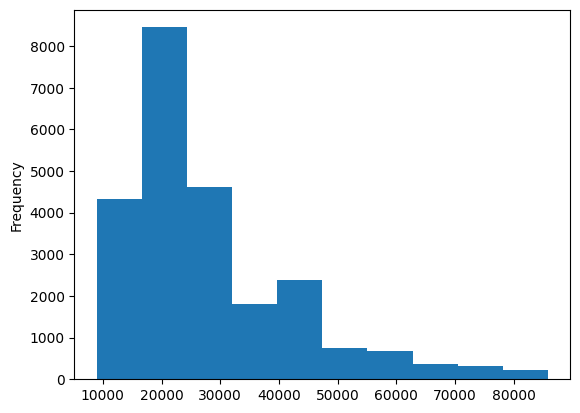

In [ ]:
raw_df_cleaned['Price ($)'].plot.hist()

Text(0.5, 1.0, 'Box Plot of Price ($)')

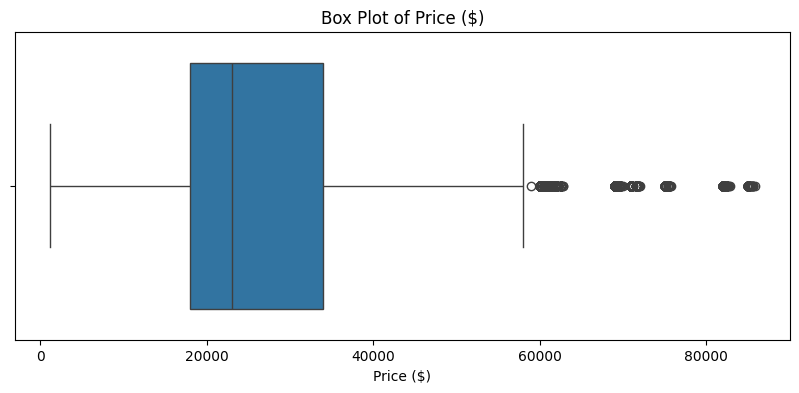

In [ ]:
plt.figure(figsize=(10, 4))
sns.boxplot(x=raw_df['Price ($)'])
plt.title(f'Box Plot of Price ($)')
#plt.show()

## Dealer_No
Summary:
- a 7-level categorical
- is a generalization of Dealer_Name: every Dealer_No correponds to 4 Dealer_Name

In [ ]:
# Convert column to category dtype
raw_df['Dealer_No'] = raw_df['Dealer_No'].astype('category')

In [ ]:
raw_df['Dealer_No'].value_counts()

Dealer_No
85257-3102    3814
53546-9427    3813
78758-7841    3753
06457-3834    3132
38701-8047    3132
99301-3882    3132
60504-7114    3130
Name: count, dtype: int64

## Body Style
A 4-level categorical

In [ ]:
unique_bodies = raw_df[['Body Style']].drop_duplicates()
print(unique_bodies)

   Body Style
0         SUV
2   Passenger
4   Hatchback
8     Hardtop
14      Sedan


In [ ]:
# Convert column to category dtype
raw_df['Body Style'] = raw_df['Body Style'].astype('category')

In [ ]:
raw_df['Body Style'].value_counts()

Body Style
SUV          6374
Hatchback    6128
Sedan        4488
Passenger    3945
Hardtop      2971
Name: count, dtype: int64

## Phone†
This column is eventually dropped since phone number cannot identify unique customers, and it doesn't make business sense that phone number will affect claims.

In [ ]:
raw_df['Phone'].astype('str').value_counts().head()

Phone
6005535    2
7298842    2
6955907    2
6854031    2
8895808    2
Name: count, dtype: int64

In [ ]:
unique_pairs = raw_df[['Customer Name', 'Phone']].drop_duplicates()
unique_pairs

,Customer Name,Phone
0,Geraldine,8264678
1,Gia,6848189
2,Gianna,7298798
3,Giselle,6257557
4,Grace,7081483
...,...,...
23901,Martin,8583598
23902,Jimmy,7914229
23903,Emma,7659127
23904,Victoire,6030764


In [ ]:
raw_df[raw_df['Phone'].map(raw_df['Phone'].value_counts()) > 1][['Customer Name', 'Phone']]

,Customer Name,Phone
278,Alvin,8429371
325,Marcus,7410063
347,Kaylee,8138829
618,Clement,6015528
659,Romane,7298842
...,...,...
23089,Veronica,7150746
23169,Claire,6461849
23312,Hailey,8535490
23352,August,7171469


In [ ]:
raw_df[raw_df['Phone'] == 7410063]['Customer Name']

325     Marcus
2608    Janice
Name: Customer Name, dtype: object

In [ ]:
raw_df.iloc[[325, 2608]][['Customer Name', 'Gender', 'Annual Income', 'Dealer_Name', 'Company', 'Model', 'Engine', 'Transmission', 'Color', 'Price ($)', 'Dealer_No', 'Body Style', 'Phone', 'Amount_paid_for_insurance', 'Claim amount', 'City']]

,Customer Name,Gender,Annual Income,Dealer_Name,Company,Model,Engine,Transmission,Color,Price ($),Dealer_No,Body Style,Phone,Amount_paid_for_insurance,Claim amount,City
325,Marcus,Male,1100000,Progressive Shippers Cooperative Association No,Toyota,RAV4,Overhead Camshaft,Manual,Pale White,22000,53546-9427,Hatchback,7410063,1489,0.000,Jelgava
2608,Janice,Male,2268000,Rabun Used Car Sales,Toyota,Celica,DoubleÃ‚Â Overhead Camshaft,Auto,Pale White,45800,85257-3102,SUV,7410063,2578,0.000,Tukums


In [ ]:
raw_df['Phone'] = raw_df['Phone'].astype('str')

In [ ]:
raw_df = raw_df.drop('Phone', axis=1)

In [ ]:
raw_df = raw_df.drop('Customer Name', axis=1)

## Amount_paid_for_insurance
Large outliers exist and may need to be removed when modeling. See box plot. \
This is understood as the premium paid by the policyholder.

In [ ]:
# Setting the display option to avoid scientific notation
pd.set_option('display.float_format', '{:.3f}'.format)

raw_df['Amount_paid_for_insurance'].describe()

count   23906.000
mean     1654.518
std       753.482
min       103.000
25%      1138.000
50%      1432.000
75%      1990.000
max      4762.000
Name: Amount_paid_for_insurance, dtype: float64

<Axes: ylabel='Frequency'>

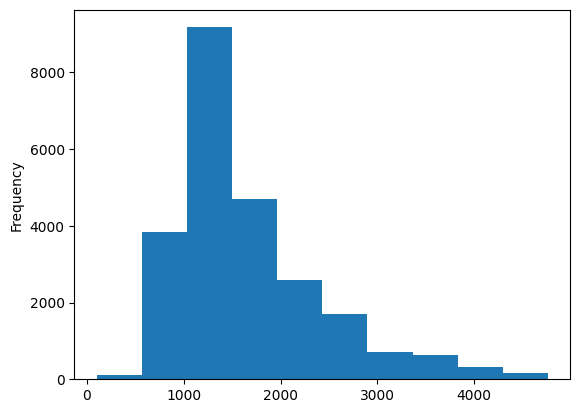

In [ ]:
raw_df['Amount_paid_for_insurance'].plot.hist()

<Axes: ylabel='Frequency'>

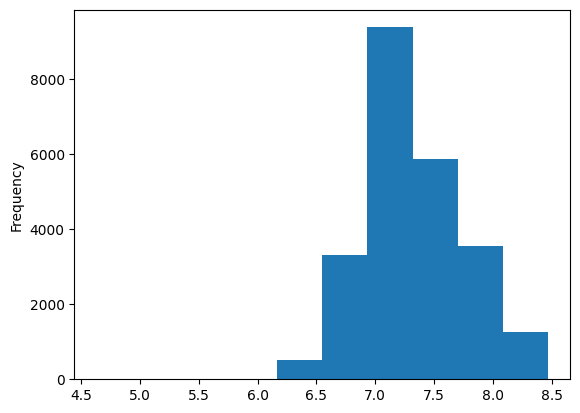

In [ ]:
#import numpy as np
np.log(raw_df['Amount_paid_for_insurance']).plot.hist()

In [ ]:
raw_df[['Amount_paid_for_insurance']].nsmallest(10, 'Amount_paid_for_insurance')

,Amount_paid_for_insurance
13996,103
14010,187
3289,450
9357,453
290,460
17765,463
940,464
17352,464
7005,465
797,470


In [ ]:
raw_df[raw_df['Amount_paid_for_insurance'] <= 500].shape[0]

35

In [ ]:
raw_df[['Amount_paid_for_insurance']].nlargest(10, 'Amount_paid_for_insurance')

,Amount_paid_for_insurance
17129,4762
11428,4753
8004,4749
23443,4748
18428,4738
8020,4737
22327,4733
17163,4726
1973,4724
5382,4698


In [ ]:
raw_df[raw_df['Amount_paid_for_insurance'] >= 4600].shape[0]

32

Text(0.5, 1.0, 'Box Plot of Amount_paid_for_insurance')

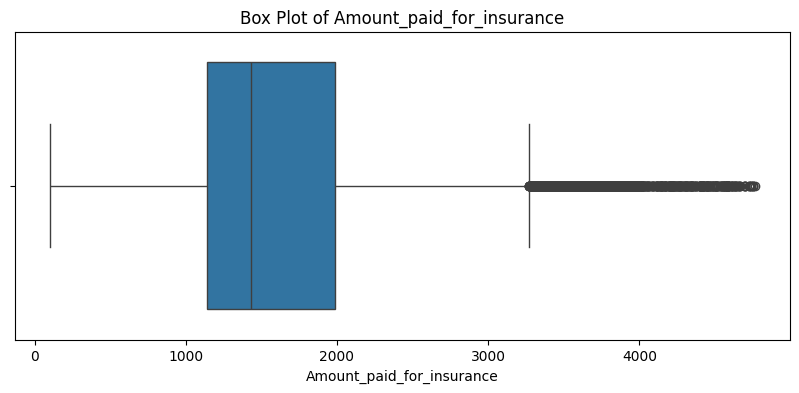

In [ ]:
plt.figure(figsize=(10, 4))
sns.boxplot(x=raw_df['Amount_paid_for_insurance'])
plt.title(f'Box Plot of Amount_paid_for_insurance')
#plt.show()

## Claim amount&
Summary:
- Large outliers exist and may need to be removed when modeling. See box plot. 
- This is understood as the claim amount paid to the policyholder when >0, traditionally referred to as 'severity.'
- A new column and target variable 'Claim' is created from this, and Claim=1 when Claim amount >0.
- "Claim" can be seen as the traditional claim frequency in the actuarial literature, since we only know if a claim happen or not, and all policyholders are unique in this dataset.

In [ ]:
raw_df['Claim amount'].apply(float.is_integer).all()

True

In [ ]:
# Convert column to category dtype
raw_df['Claim amount'] = raw_df['Claim amount'].astype('int64')

In [ ]:
# Setting the display option to avoid scientific notation
pd.set_option('display.float_format', '{:.3f}'.format)

raw_df['Claim amount'].describe()

count   23906.000
mean      282.463
std       977.507
min         0.000
25%         0.000
50%         0.000
75%         0.000
max      8560.000
Name: Claim amount, dtype: float64

In [ ]:
claimed_df = raw_df[raw_df['Claim amount'] > 0]
claimed_df['Claim amount'].describe()

count   2390.000
mean    2825.342
std     1540.676
min      145.000
25%     1800.000
50%     2200.000
75%     3500.000
max     8560.000
Name: Claim amount, dtype: float64

<Axes: ylabel='Frequency'>

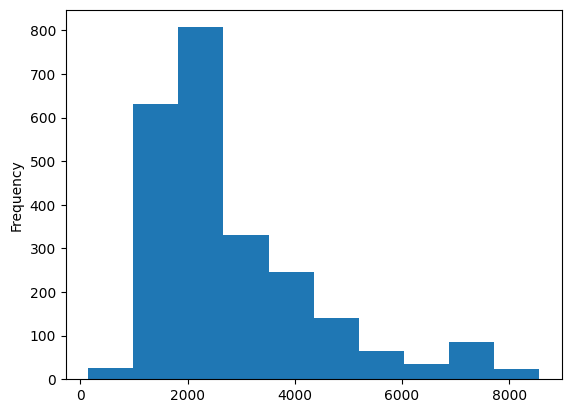

In [ ]:
claimed_df['Claim amount'].plot.hist()

<Axes: ylabel='Frequency'>

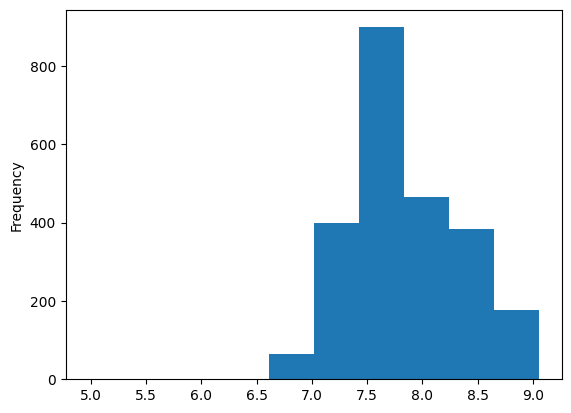

In [ ]:
#import numpy as np
np.log(claimed_df['Claim amount']).plot.hist()

In [ ]:
raw_df['Claim'] = raw_df['Claim amount'].apply(lambda x: True if x > 0 else False)
raw_df['Claim']

0        False
1         True
2        False
3        False
4         True
         ...  
23901     True
23902    False
23903    False
23904     True
23905    False
Name: Claim, Length: 23906, dtype: bool

Text(0.5, 1.0, 'Box Plot of Claim amount when claim occured')

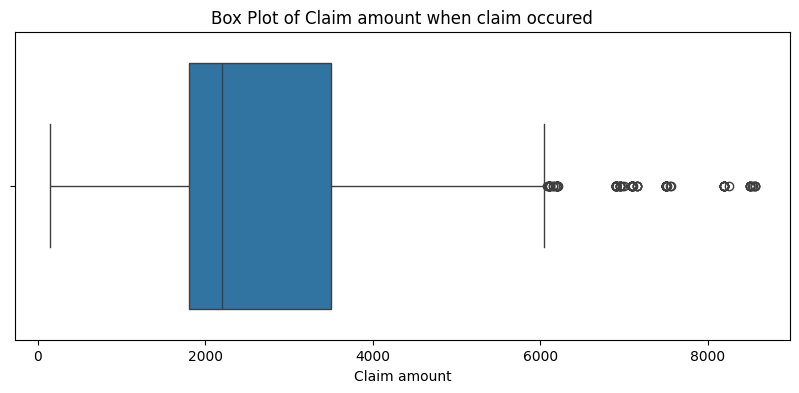

In [ ]:
plt.figure(figsize=(10, 4))
sns.boxplot(x=claimed_df['Claim amount'])
plt.title(f'Box Plot of Claim amount when claim occured')
#plt.show()

## City
A 6-level categorical

In [ ]:
unique_cities = raw_df[['City']].drop_duplicates()
print(unique_cities)

          City
0         Riga
1      Liepaja
3      Jelgava
8    Ventspils
13  Daugavpils
18      Tukums


In [ ]:
# Convert column to category dtype
raw_df['City'] = raw_df['City'].astype('category')

In [ ]:
raw_df['City'].value_counts()

City
Liepaja       4057
Tukums        4008
Riga          3987
Daugavpils    3976
Jelgava       3960
Ventspils     3918
Name: count, dtype: int64

## Features overview, Pairs
Summary:
- here is the transformed df after the EDA above
- from the plot, we can see Price ($), Annual income, and Amount_paid_for_insurance are highly correlated with one another, especially when we only look at claims that had payout (claim amount >0)

### EDA results

In [ ]:
raw_df = raw_df[['Year', 'Month', 'Day', 'Day_of_week', 'Gender', 'Annual Income', 'Dealer_Name', 'Company', 'Model', 'Engine', 'Transmission', 'Color', 'Price ($)', 'Dealer_No', 'Body Style', 'Amount_paid_for_insurance', 'Claim', 'Claim amount', 'City']]

In [ ]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23906 entries, 0 to 23905
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   Year                       23906 non-null  category
 1   Month                      23906 non-null  category
 2   Day                        23906 non-null  category
 3   Day_of_week                23906 non-null  category
 4   Gender                     23906 non-null  category
 5   Annual Income              23906 non-null  int64   
 6   Dealer_Name                23906 non-null  category
 7   Company                    23906 non-null  category
 8   Model                      23906 non-null  category
 9   Engine                     23906 non-null  category
 10  Transmission               23906 non-null  category
 11  Color                      23906 non-null  category
 12  Price ($)                  23906 non-null  int64   
 13  Dealer_No                  2390

In [ ]:
raw_df.head(10)

,Year,Month,Day,Day_of_week,Gender,Annual Income,Dealer_Name,Company,Model,Engine,Transmission,Color,Price ($),Dealer_No,Body Style,Amount_paid_for_insurance,Claim,Claim amount,City
0,2022,1,2,Sunday,Male,13500,Buddy Storbeck's Diesel Service Inc,Ford,Expedition,DoubleÃ‚Â Overhead Camshaft,Auto,Black,26000,06457-3834,SUV,1665,False,0,Riga
1,2022,1,2,Sunday,Male,1480000,C & M Motors Inc,Dodge,Durango,DoubleÃ‚Â Overhead Camshaft,Auto,Black,19000,60504-7114,SUV,1332,True,1900,Liepaja
2,2022,1,2,Sunday,Male,1035000,Capitol KIA,Cadillac,Eldorado,Overhead Camshaft,Manual,Red,31500,38701-8047,Passenger,1897,False,0,Riga
3,2022,1,2,Sunday,Male,13500,Chrysler of Tri-Cities,Toyota,Celica,Overhead Camshaft,Manual,Pale White,14000,99301-3882,SUV,1176,False,0,Jelgava
4,2022,1,2,Sunday,Male,1465000,Chrysler Plymouth,Acura,TL,DoubleÃ‚Â Overhead Camshaft,Auto,Red,24500,53546-9427,Hatchback,1323,True,2450,Liepaja
5,2022,1,2,Sunday,Male,850000,Classic Chevy,Mitsubishi,Diamante,Overhead Camshaft,Manual,Pale White,12000,85257-3102,Hatchback,830,False,0,Riga
6,2022,1,2,Sunday,Male,1600000,Clay Johnson Auto Sales,Toyota,Corolla,Overhead Camshaft,Manual,Pale White,14000,78758-7841,Passenger,717,False,0,Riga
7,2022,1,2,Sunday,Male,13500,U-Haul CO,Mitsubishi,Galant,DoubleÃ‚Â Overhead Camshaft,Auto,Pale White,42000,78758-7841,Passenger,2183,False,0,Jelgava
8,2022,1,2,Sunday,Male,815000,Rabun Used Car Sales,Chevrolet,Malibu,Overhead Camshaft,Manual,Pale White,82000,85257-3102,Hardtop,4206,False,0,Ventspils
9,2022,1,2,Sunday,Female,13500,Rabun Used Car Sales,Ford,Escort,DoubleÃ‚Â Overhead Camshaft,Auto,Pale White,15000,85257-3102,Passenger,873,False,0,Ventspils


### heatmap, pairplot (all)

Text(0.5, 1.0, 'Correlation Matrix Heatmap')

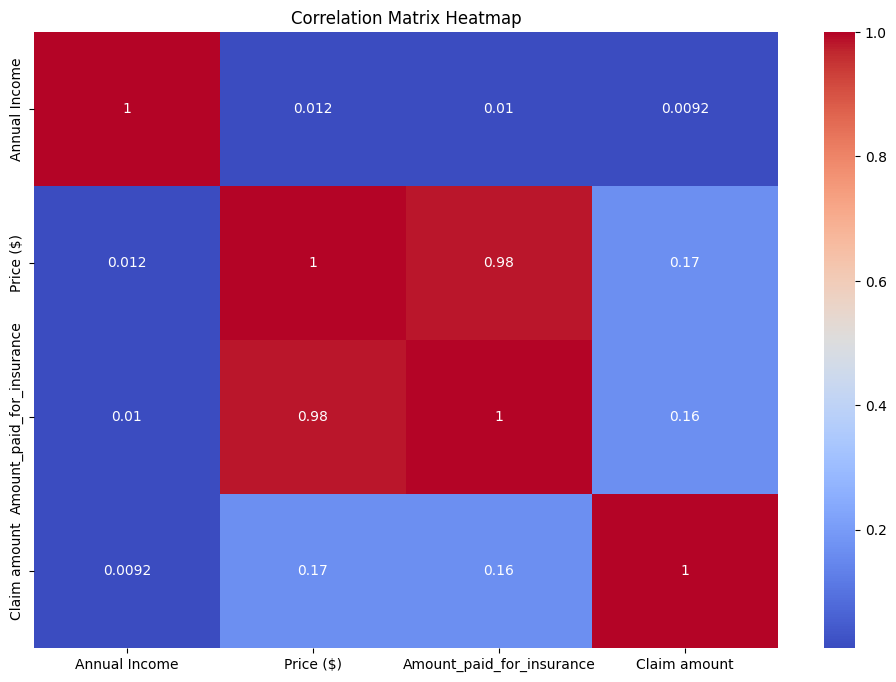

In [ ]:
#import seaborn as sns
#import matplotlib.pyplot as plt

# Select only numerical columns
numerical_columns = raw_df.select_dtypes(include=['int64', 'float64'])

# Correlation matrix
corr_matrix = numerical_columns.corr()

# Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
#plt.show()

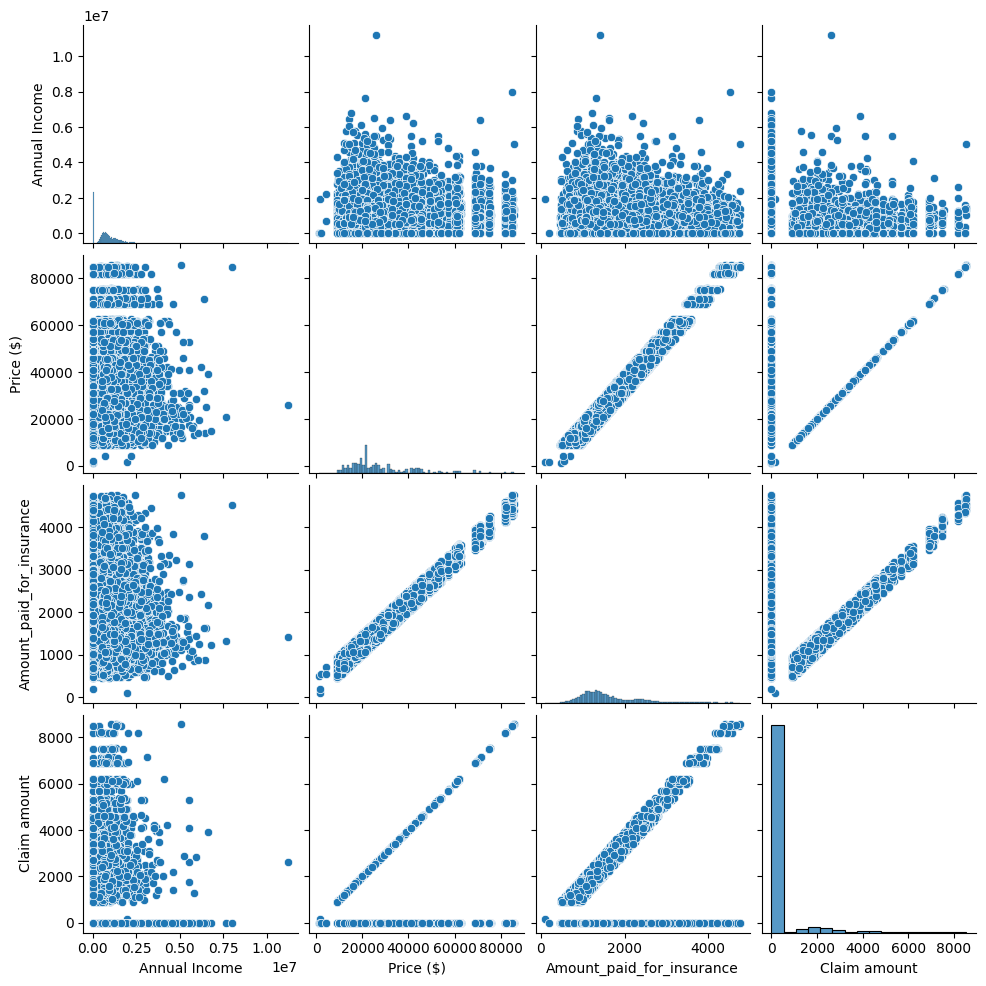

In [ ]:
sns.pairplot(raw_df, vars = numerical_columns)
#plt.show()

### heatmap, pairplot (Claim amount>0)

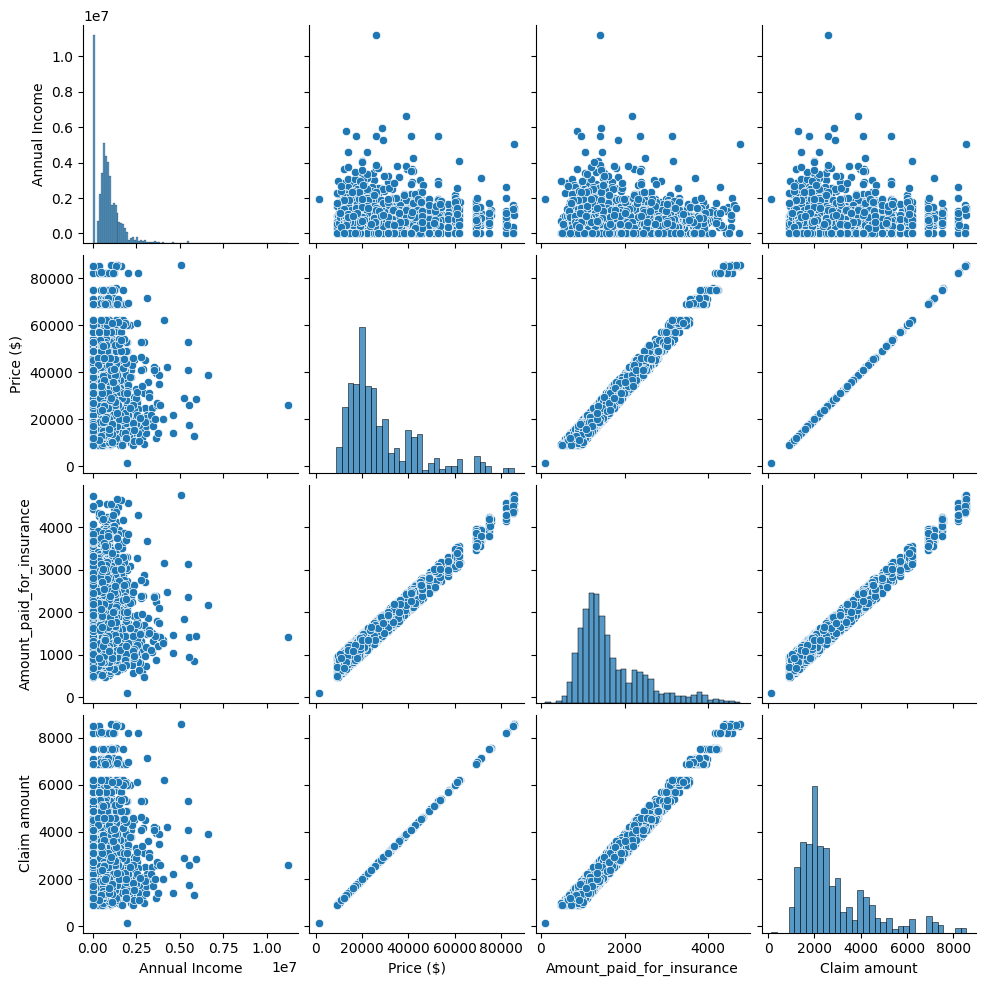

In [ ]:
claimed_df = raw_df[raw_df['Claim amount'] > 0].reset_index(drop=True)
sns.pairplot(claimed_df, vars = numerical_columns)
#plt.show()

Text(0.5, 1.0, 'Correlation Matrix Heatmap')

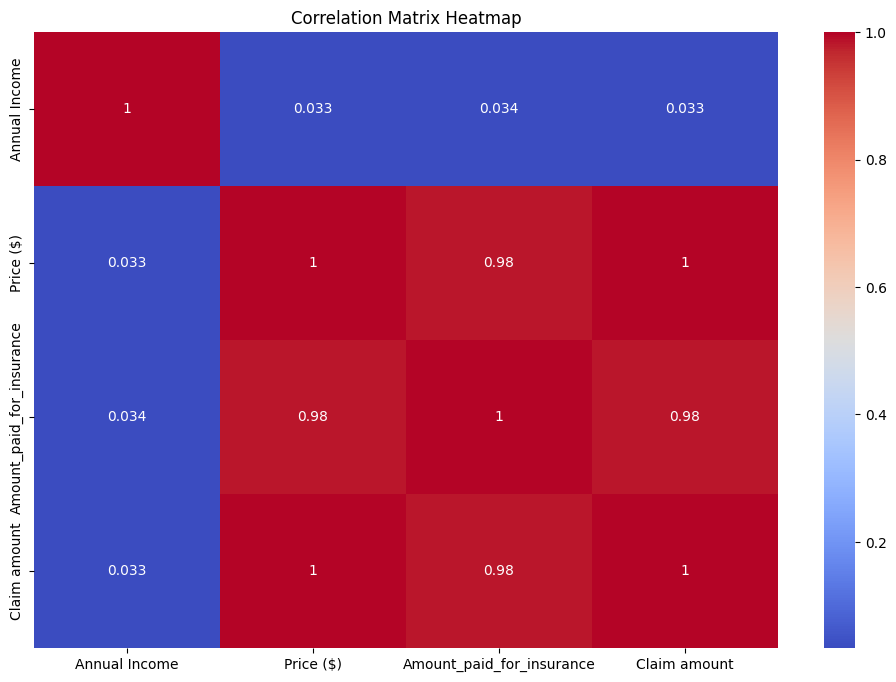

In [ ]:
#claimed_df = raw_df[raw_df['Claim amount'] > 0].reset_index(drop=True)

# Select only numerical columns
claimed_numerical_columns = claimed_df.select_dtypes(include=['int64', 'float64'])

# Correlation matrix
claimed_corr_matrix = claimed_numerical_columns.corr()

# Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(claimed_corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
#plt.show()

## Feature Importance (RF)
- For both severity and frequency modeling alike, the numerical data are more important.
- Of the categoricals, 'Model', 'Day', 'Dealer_Name', 'Company' have the highest predicting power to both frequency and severity.

### Severity

#### Numericals + Categoriclas (One-Hot)

In [ ]:
claimed_df = claimed_df.drop('Claim', axis=1).reset_index(drop=True)

In [ ]:
claimed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2390 entries, 0 to 2389
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   Year                       2390 non-null   category
 1   Month                      2390 non-null   category
 2   Day                        2390 non-null   category
 3   Day_of_week                2390 non-null   category
 4   Gender                     2390 non-null   category
 5   Annual Income              2390 non-null   int64   
 6   Dealer_Name                2390 non-null   category
 7   Company                    2390 non-null   category
 8   Model                      2390 non-null   category
 9   Engine                     2390 non-null   category
 10  Transmission               2390 non-null   category
 11  Color                      2390 non-null   category
 12  Price ($)                  2390 non-null   int64   
 13  Dealer_No                  2390 n

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

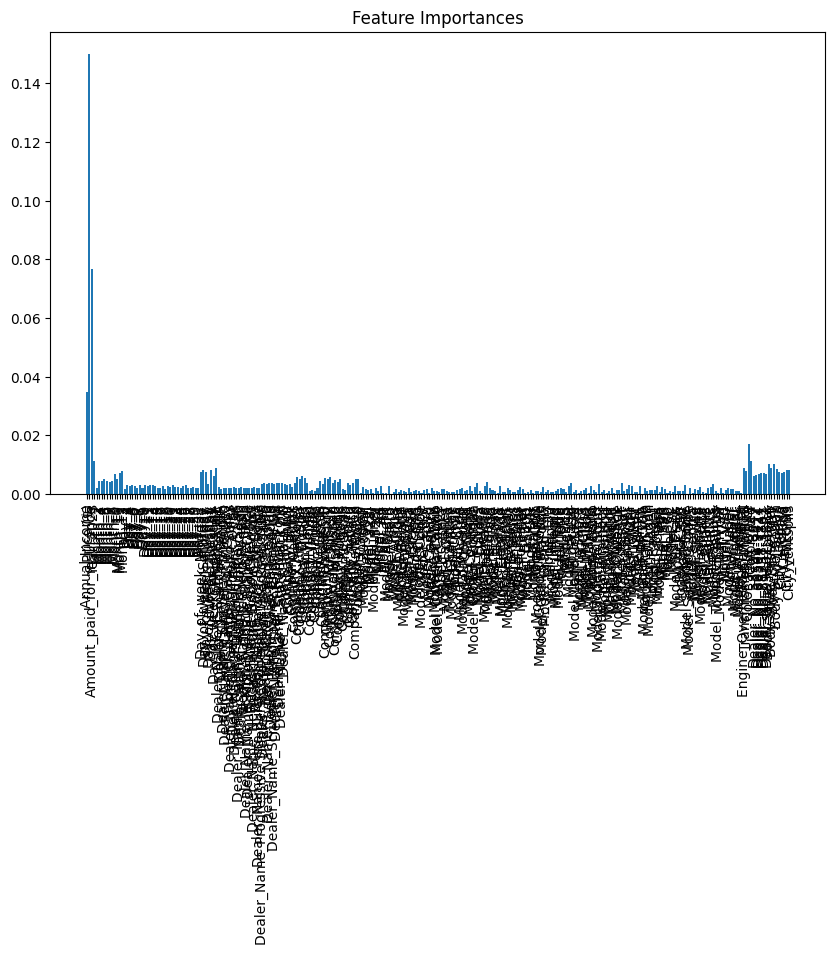

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
#import pandas as pd
#import matplotlib.pyplot as plt

# Select only categorical columns
claimed_categorical_columns = claimed_df.select_dtypes(include=['category'])

# One-hot encode categorical variables
RF_encoder = OneHotEncoder(drop='first', sparse_output=False)
Claimed_X_encoded = RF_encoder.fit_transform(claimed_categorical_columns)

# Convert encoded features to DataFrame
Claimed_X_encoded_df = pd.DataFrame(Claimed_X_encoded, columns=RF_encoder.get_feature_names_out(claimed_categorical_columns.columns))

# Combine encoded features with numerical features
Claimed_X = pd.concat([claimed_df.drop(columns=claimed_categorical_columns), Claimed_X_encoded_df], axis=1)
Claimed_X = Claimed_X.drop(columns='Claim amount')

# Train Random Forest model
Claimed_rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
Claimed_y = claimed_df['Claim amount']
Claimed_rf_model.fit(Claimed_X, Claimed_y)

# Get feature importances
importances = Claimed_rf_model.feature_importances_

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(Claimed_X.shape[1]), importances, tick_label=Claimed_X.columns)
plt.title("Feature Importances")
plt.xticks(rotation=90)
#plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_top_feature_importances(importances, feature_names, N):
    """
    Plot the top N feature importances.

    Parameters:
    - importances (array-like): Feature importances.
    - feature_names (array-like): Names of the features.
    - N (int): Number of top features to plot.
    """
    # Get indices of top N feature importances
    top_n_indices = np.argsort(importances)[::-1][:N]

    # Get names of top N features
    top_n_features = feature_names[top_n_indices]

    # Get importances of top N features
    top_n_importances = importances[top_n_indices]

    # Plot top N feature importances
    plt.figure(figsize=(15, 6))
    plt.bar(range(len(top_n_features)), top_n_importances, tick_label=top_n_features)
    plt.title("Top {} Feature Importances".format(N))
    plt.xticks(rotation=90)
    plt.show()

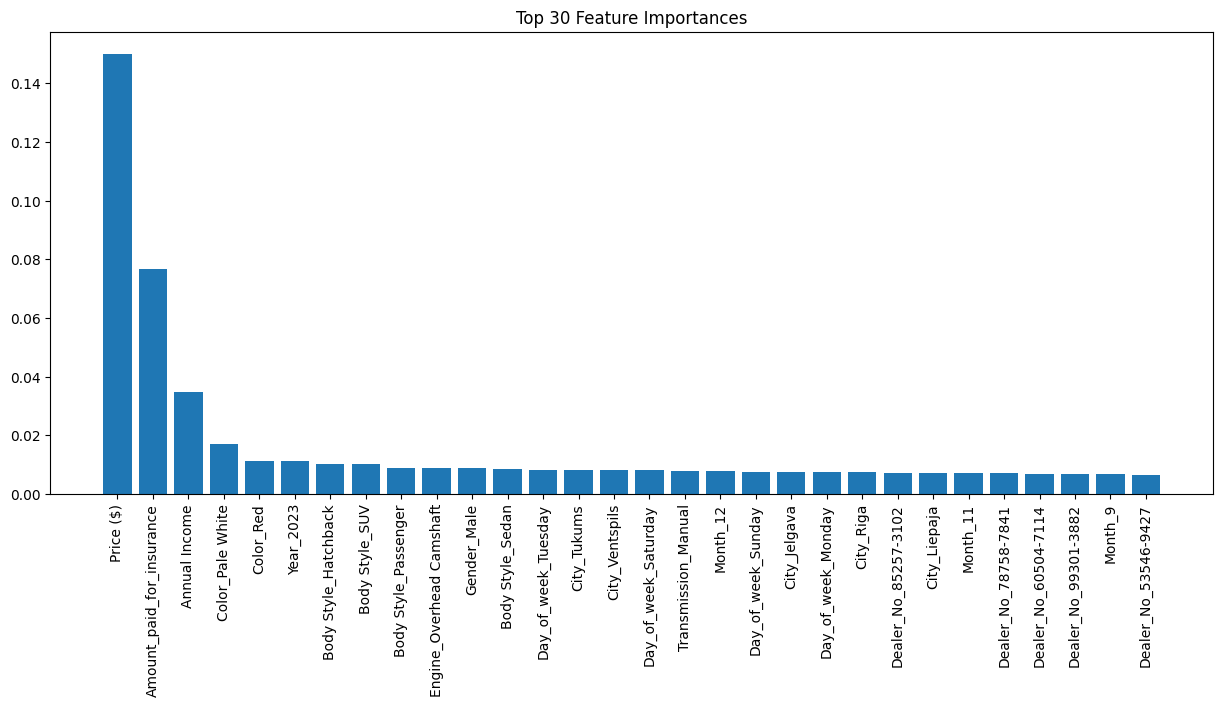

In [ ]:
plot_top_feature_importances(importances, Claimed_X.columns, 30)

#### Numericals + Categoriclas (Label)

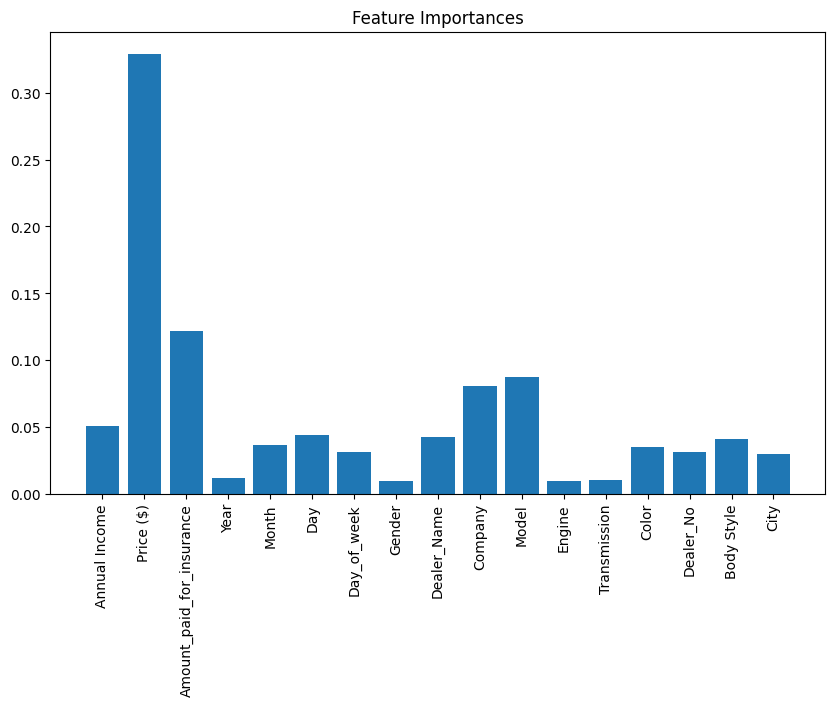

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Select only categorical columns
claimed_categorical_columns = claimed_df.select_dtypes(include=['category'])

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encode each categorical column
Claimed_X_encoded = pd.DataFrame()  # DataFrame to store encoded features
for col in claimed_categorical_columns.columns:
    encoded_labels = label_encoder.fit_transform(claimed_categorical_columns[col])
    Claimed_X_encoded[col] = encoded_labels

# Combine encoded features with numerical features
Claimed_X = pd.concat([claimed_df.drop(columns=claimed_categorical_columns), Claimed_X_encoded], axis=1)
Claimed_X = Claimed_X.drop(columns='Claim amount')

# Train Random Forest model
Claimed_rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
Claimed_y = claimed_df['Claim amount']
Claimed_rf_model.fit(Claimed_X, Claimed_y)

# Get feature importances
importances = Claimed_rf_model.feature_importances_

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(Claimed_X.shape[1]), importances, tick_label=Claimed_X.columns)
plt.title("Feature Importances")
plt.xticks(rotation=90)
plt.show()

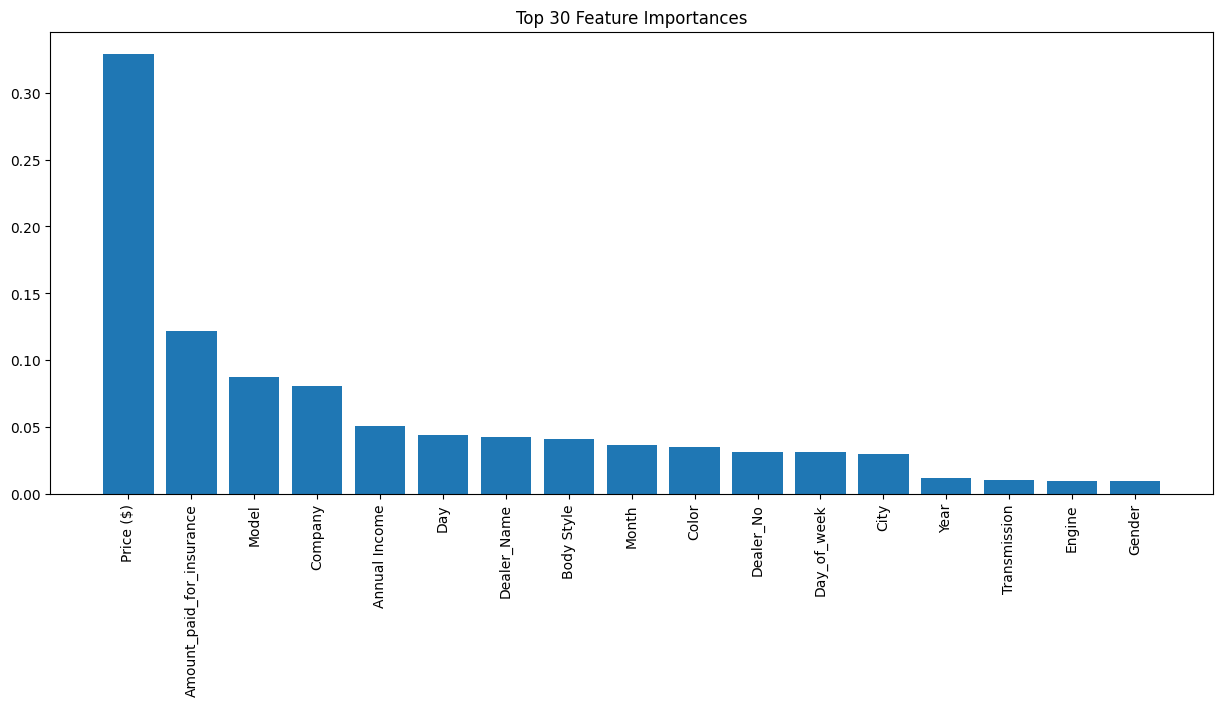

In [ ]:
plot_top_feature_importances(importances, Claimed_X.columns, 30)

#### Categoricals (Ordinal+Label)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 [Text(0, 0, 'Year'),
  Text(1, 0, 'Month'),
  Text(2, 0, 'Day'),
  Text(3, 0, 'Day_of_week'),
  Text(4, 0, 'Gender'),
  Text(5, 0, 'Dealer_Name'),
  Text(6, 0, 'Company'),
  Text(7, 0, 'Model'),
  Text(8, 0, 'Engine'),
  Text(9, 0, 'Transmission'),
  Text(10, 0, 'Color'),
  Text(11, 0, 'Dealer_No'),
  Text(12, 0, 'Body Style'),
  Text(13, 0, 'City')])

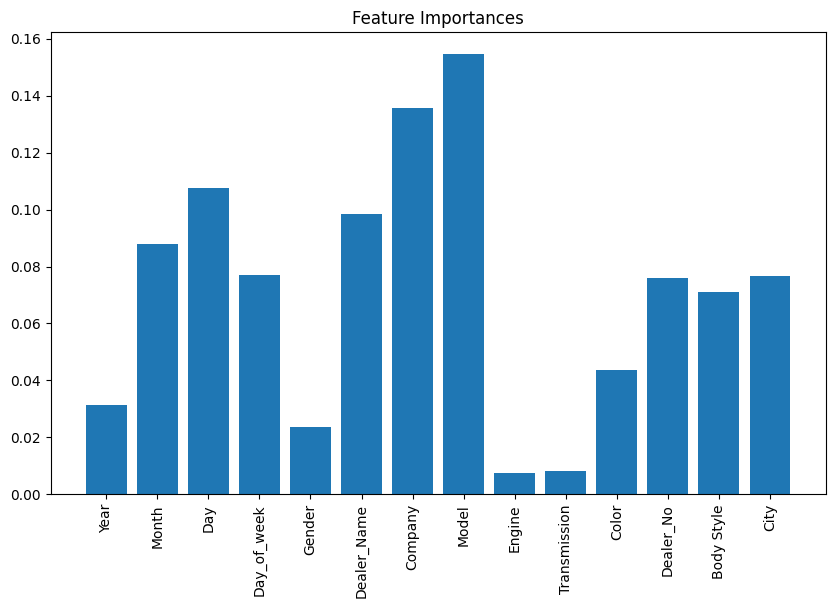

In [ ]:
#from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
#import pandas as pd
#import matplotlib.pyplot as plt

# Select only categorical columns
claimed_categorical_columns = claimed_df.select_dtypes(include=['category'])

# Select
claimed_oridnal_columns = claimed_categorical_columns[['Year', 'Month', 'Day', 'Day_of_week']]

# Encode
RF_oridnal_encoder = OrdinalEncoder()
Claimed_X_oridnal_encoded = RF_oridnal_encoder.fit_transform(claimed_oridnal_columns)

# Convert encoded features to DataFrame
Claimed_X_oridnal_encoded_df = pd.DataFrame(Claimed_X_oridnal_encoded, columns=claimed_oridnal_columns.columns)

# Initialize a dictionary to store original categories and encoded labels
label_dict = {}

# Select
claimed_labeled_columns = claimed_categorical_columns.drop(columns=claimed_oridnal_columns)

# Encode
RF_labeled_encoder = LabelEncoder()
for col in claimed_labeled_columns.columns:
    claimed_labeled_columns[col] = RF_labeled_encoder.fit_transform(claimed_labeled_columns[col])
    label_dict[col] = dict(zip(RF_labeled_encoder.classes_, RF_labeled_encoder.transform(RF_labeled_encoder.classes_)))

# Combine both encoded features
Claimed_categorical_X = pd.concat([Claimed_X_oridnal_encoded_df, claimed_labeled_columns], axis=1)

# Train Random Forest model
Claimed_rf_model_categorical = RandomForestClassifier(n_estimators=100, random_state=42)
Claimed_y = claimed_df['Claim amount']
Claimed_rf_model_categorical.fit(Claimed_categorical_X, Claimed_y)

# Get feature importances
importances_categorical = Claimed_rf_model_categorical.feature_importances_

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(Claimed_categorical_X.shape[1]), importances_categorical, tick_label=Claimed_categorical_X.columns)
plt.title("Feature Importances")
plt.xticks(rotation=90)
#plt.show()

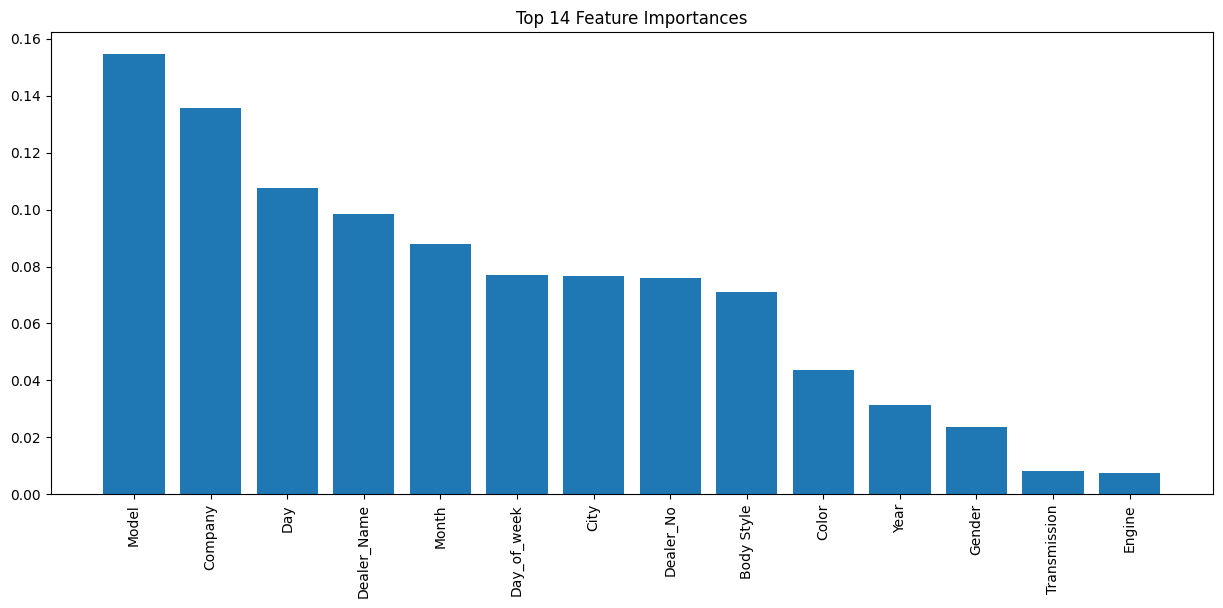

In [ ]:
plot_top_feature_importances(importances_categorical, Claimed_categorical_X.columns, 14)

### Frequency

#### Numericals + Categoriclas (Label)

In [ ]:
freq_df = raw_df.drop('Claim amount', axis=1).reset_index(drop=True)

In [ ]:
freq_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23906 entries, 0 to 23905
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   Year                       23906 non-null  category
 1   Month                      23906 non-null  category
 2   Day                        23906 non-null  category
 3   Day_of_week                23906 non-null  category
 4   Gender                     23906 non-null  category
 5   Annual Income              23906 non-null  int64   
 6   Dealer_Name                23906 non-null  category
 7   Company                    23906 non-null  category
 8   Model                      23906 non-null  category
 9   Engine                     23906 non-null  category
 10  Transmission               23906 non-null  category
 11  Color                      23906 non-null  category
 12  Price ($)                  23906 non-null  int64   
 13  Dealer_No                  2390

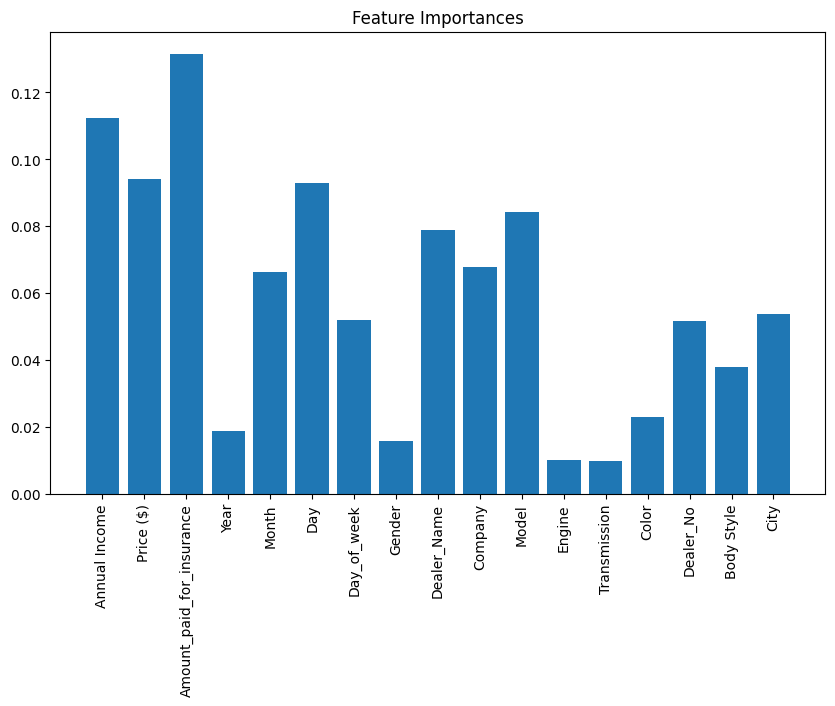

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Select only categorical columns
freq_categorical_columns = freq_df.select_dtypes(include=['category'])

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encode each categorical column
freq_X_encoded = pd.DataFrame()  # DataFrame to store encoded features
for col in freq_categorical_columns.columns:
    encoded_labels = label_encoder.fit_transform(freq_categorical_columns[col])
    freq_X_encoded[col] = encoded_labels

# Combine encoded features with numerical features
freq_X = pd.concat([freq_df.drop(columns=freq_categorical_columns), freq_X_encoded], axis=1)
freq_X = freq_X.drop(columns='Claim')

# Train Random Forest model
freq_rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
freq_y = freq_df['Claim']
freq_rf_model.fit(freq_X, freq_y)

# Get feature importances
freq_importances = freq_rf_model.feature_importances_

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(freq_X.shape[1]), freq_importances, tick_label=freq_X.columns)
plt.title("Feature Importances")
plt.xticks(rotation=90)
plt.show()

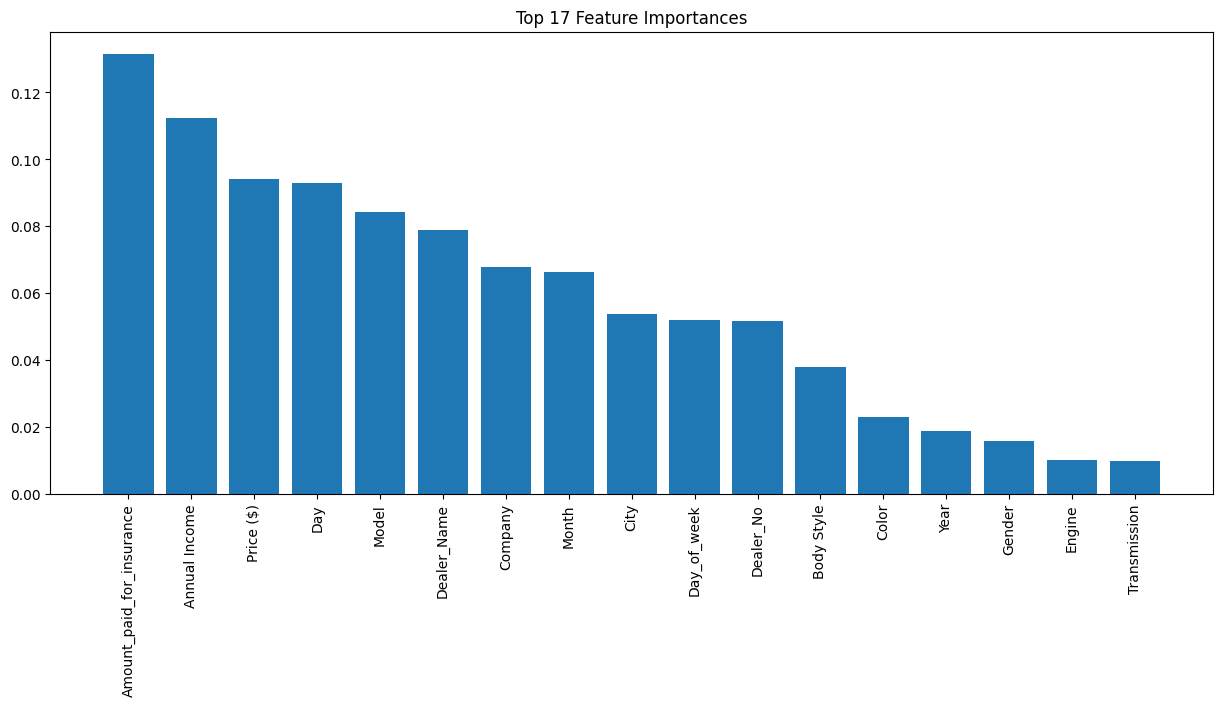

In [ ]:
plot_top_feature_importances(freq_importances, freq_X.columns, 17)

## Severity/Frequenct dfs
Overview of the dataframe available for later modeling purpose, including a summary of all dataframes created in the Feature Importance section.

In [ ]:
claimed_df = raw_df[raw_df['Claim amount'] > 0]
severity_df = claimed_df.drop('Claim', axis=1).reset_index(drop=True)

In [ ]:
freq_df = raw_df.drop('Claim amount', axis=1).reset_index(drop=True)

**Severity:**
- Numericals + Categoriclas (One-Hot): \
Claimed_X = Claimed_X.drop(columns='Claim amount') \
Claimed_y = claimed_df['Claim amount']
- Numericals + Categoriclas (Label): \
Claimed_X = Claimed_X.drop(columns='Claim amount') \
Claimed_y = claimed_df['Claim amount']
- Categoricals (Ordinal+Label) \
Claimed_categorical_X = pd.concat([Claimed_X_oridnal_encoded_df,
Claimed_y = claimed_df['Claim amount']


**Frequency:** 
- Numericals + Categoriclas (Label): \
freq_X = freq_X.drop(columns='Claim') \
freq_y = freq_df['Claim']

## Clustering (t-sne)
The severity (claim amount) df shows potential clustering.

#### Severity 2-D plot

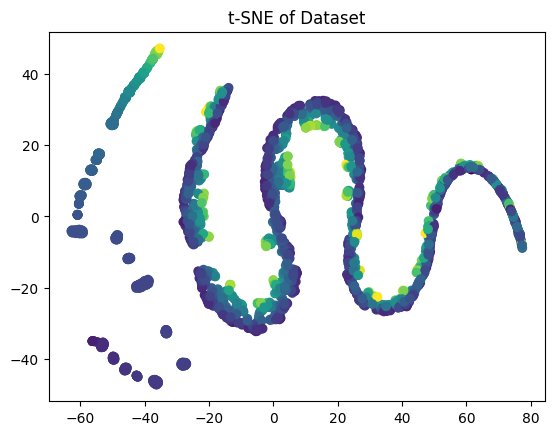

In [ ]:
'''
# Severity

from sklearn.manifold import TSNE

tsne = TSNE(n_components = 2)
tsne_result = tsne.fit_transform(Claimed_X)
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c = Claimed_y)
plt.title('t-SNE of Dataset')
plt.show()
'''

#### Frequency 2-D plot

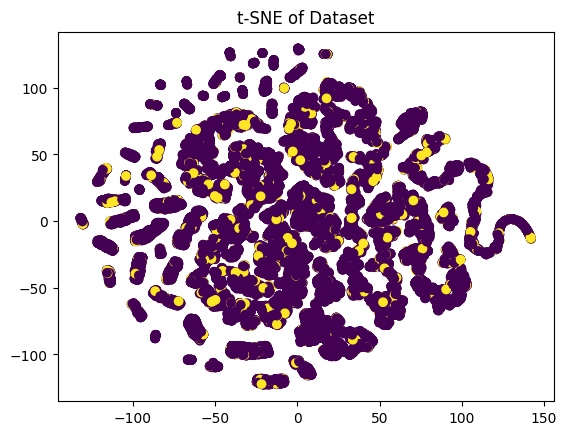

In [ ]:
'''
# Frequency

from sklearn.manifold import TSNE

tsne = TSNE(n_components = 2)
tsne_result = tsne.fit_transform(freq_X)
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c = freq_y)
plt.title('t-SNE of Dataset')
plt.show()
'''

# Modeling example: severity
The following section demonstrates two ways to model the severity data; model evaluation is omitted for this purpose. Proper pre-processing are done for each, though.
- Generalized linear model: traditional actuarial method to model non-life insurance data. Explainable.
- Neural network: Black box.

In [ ]:
claimed_df = raw_df[raw_df['Claim amount'] > 0]
severity_df = claimed_df.drop('Claim', axis=1).reset_index(drop=True)
severity_df.rename(columns={'Price ($)': 'Price_USD', 'Annual Income': 'Annual_income', 'Body Style' : 'Body_style', 'Claim amount' : 'Claim_amount'}, inplace=True)
severity_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2390 entries, 0 to 2389
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   Year                       2390 non-null   category
 1   Month                      2390 non-null   category
 2   Day                        2390 non-null   category
 3   Day_of_week                2390 non-null   category
 4   Gender                     2390 non-null   category
 5   Annual_income              2390 non-null   int64   
 6   Dealer_Name                2390 non-null   category
 7   Company                    2390 non-null   category
 8   Model                      2390 non-null   category
 9   Engine                     2390 non-null   category
 10  Transmission               2390 non-null   category
 11  Color                      2390 non-null   category
 12  Price_USD                  2390 non-null   int64   
 13  Dealer_No                  2390 n

## Exploratory GLM
- We first fit a Gamma (due to the heavy tail and following common assumption in the literature) GLM to gain insights and early results

Pick out the variables for modeling severity.
- target: `Claim amount`
- predictors: 1 continuous and 9 categorical

*In actuarial literature, the target is usually average claim amount per customer over a year. Since all customers are treated as unique, and all claims only happen once, we simply use `Claim amount` as the target for this dataset.

Standardize the continuous variables

In [ ]:
# standardization
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
cols_to_scale = ["Annual_income", "Price_USD", "Amount_paid_for_insurance"]

# create and fit scaler
scaler = StandardScaler()
scaler.fit(severity_df[cols_to_scale])

# scale selected data
severity_df[cols_to_scale] = scaler.transform(severity_df[cols_to_scale])

# check result
print(severity_df[cols_to_scale].mean())
print(severity_df[cols_to_scale].var())

Annual_income               -0.000
Price_USD                   -0.000
Amount_paid_for_insurance    0.000
dtype: float64
Annual_income               1.000
Price_USD                   1.000
Amount_paid_for_insurance   1.000
dtype: float64


Now fit the preliminary model with all variables.

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [ ]:
# Set the formula
all_columns = "+".join(severity_df.columns.difference(["Claim_amount"]))
sev_formula = "Claim_amount~" + all_columns
print(sev_formula)

# Fit model with the formula
sev_glm = smf.glm(formula=sev_formula,
                       data=severity_df, family=sm.families.Gamma(link=sm.families.links.log())).fit()

Claim_amount~Amount_paid_for_insurance+Annual_income+Body_style+City+Color+Company+Day+Day_of_week+Dealer_Name+Dealer_No+Engine+Gender+Model+Month+Price_USD+Transmission+Year


/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


Show the fitted model.

In [ ]:
print(sev_glm.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           Claim_amount   No. Observations:                 2390
Model:                            GLM   Df Residuals:                     2148
Model Family:                   Gamma   Df Model:                          241
Link Function:                    log   Scale:                        0.012844
Method:                          IRLS   Log-Likelihood:                -16875.
Date:                Thu, 30 May 2024   Deviance:                       30.541
Time:                        17:43:55   Pearson chi2:                     27.6
No. Iterations:                   100   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                                                     coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------

## Formal GLM

A follow-up GLM with train-test split can be modeled on the more important variables. Continuous variables need to be binned first.

## Neural Network
Another example of fitting a neural network onto the severity data

In [ ]:
# Prepare dataframe
claimed_df = raw_df[raw_df['Claim amount'] > 0]
severity_df = claimed_df.drop('Claim', axis=1).reset_index(drop=True)
severity_df.rename(columns={'Price ($)': 'Price_USD', 'Annual Income': 'Annual_income', 'Body Style' : 'Body_style', 'Claim amount' : 'Claim_amount'}, inplace=True)

In [ ]:
# standardization
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
cols_to_scale = ["Annual_income", "Price_USD", "Amount_paid_for_insurance"]

# create and fit scaler
scaler = StandardScaler()
scaler.fit(severity_df[cols_to_scale])

# scale selected data
severity_df[cols_to_scale] = scaler.transform(severity_df[cols_to_scale])

# check result
print(severity_df[cols_to_scale].mean())
print(severity_df[cols_to_scale].var())

Annual_income               -0.000
Price_USD                   -0.000
Amount_paid_for_insurance    0.000
dtype: float64
Annual_income               1.000
Price_USD                   1.000
Amount_paid_for_insurance   1.000
dtype: float64


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from scipy.sparse import issparse

# Separate features and target
X = severity_df.drop(columns='Claim_amount')
y = severity_df['Claim_amount']

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['category']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64']).columns.tolist()

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first'), categorical_cols)
    ]
)

# Apply transformations
X_processed = preprocessor.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

# Convert to dense arrays if sparse
if issparse(X_train):
    X_train = X_train.toarray()
if issparse(X_test):
    X_test = X_test.toarray()

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define the neural network
class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Instantiate the model, loss function, and optimizer
input_dim = X_train.shape[1]
model = SimpleNN(input_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
n_epochs = 100
for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch {epoch+1}/{n_epochs}, Loss: {running_loss/len(train_loader)}')

# Evaluation
model.eval()
test_loss = 0.0
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        test_loss += loss.item()
print(f'Test Loss: {test_loss/len(test_loader)}')

Epoch 1/100, Loss: 10474486.258333333
Epoch 2/100, Loss: 10340391.608333332
Epoch 3/100, Loss: 9607595.941666666
Epoch 4/100, Loss: 7916979.408333333
Epoch 5/100, Loss: 5547307.625
Epoch 6/100, Loss: 3567946.785416667
Epoch 7/100, Loss: 2714780.46875
Epoch 8/100, Loss: 2525640.196875
Epoch 9/100, Loss: 2493830.765625
Epoch 10/100, Loss: 2463435.720833333
Epoch 11/100, Loss: 2450164.9791666665
Epoch 12/100, Loss: 2414242.9541666666
Epoch 13/100, Loss: 2392153.396875
Epoch 14/100, Loss: 2371403.714583333
Epoch 15/100, Loss: 2351682.3958333335
Epoch 16/100, Loss: 2332784.096875
Epoch 17/100, Loss: 2308935.9208333334
Epoch 18/100, Loss: 2290922.53125
Epoch 19/100, Loss: 2272748.196875
Epoch 20/100, Loss: 2250352.127083333
Epoch 21/100, Loss: 2230625.754166667
Epoch 22/100, Loss: 2212467.066666667
Epoch 23/100, Loss: 2197027.221875
Epoch 24/100, Loss: 2175503.9135416667
Epoch 25/100, Loss: 2154752.372916667
Epoch 26/100, Loss: 2141330.484375
Epoch 27/100, Loss: 2128112.809375
Epoch 28/100, 

# Actuarial use case example

If we also model frequency using e.g. GLM as above, we can combine it with the severity result by computing their product to obtain the **total expected loss** of this car insurance portfolio, and thus decide the **technical premium** i.e. the break-even tariff plan we should charge. Annulization should be taken into account as well.